In [7]:
import numpy as np 
from astropy.io import fits
import sim_util as su
import scipy.signal as signal
import os 
import kappa_util as ul 

In [8]:
#load kappa (convergence) map
data_path = '../manga_mass_0/mge_kappa/kappa'
data_name = '1016_8318-12701'
kappa_high_res  = fits.getdata(f'{data_path}/{data_name}.fits',0)
header = fits.getheader(f'{data_path}/{data_name}.fits',0)
dpix_high_res = header['dpix']  #subgrid pixel size in arcsec unit
subgrid = header['nsub']  #number of sub-pixels for each native ccd pixel

In [9]:
#calculate defelction angle map (alpha-map) from kappa map
alphax_lowres, alphay_lowres = ul.alpha_from_kappa_adp(kappa_high_res, dpix_high_res, subgrid)   
alphax_lowres = su.cut_image(alphax_lowres,(200,200))
alphay_lowres = su.cut_image(alphay_lowres,(200,200))

In [10]:
#generate image-plane grid
x_grid_lowres, y_grid_lowres = su.make_grid_2d(alphax_lowres.shape[0], deltapix=dpix_high_res*subgrid)
#ray-trace image-plane grid to source-plane
xsource = x_grid_lowres - alphax_lowres 
ysource = y_grid_lowres - alphay_lowres

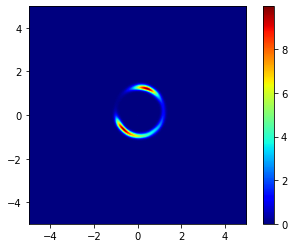

In [11]:
#suppose the light distribution of the background source galaxy is a simple spherical gauss
ideal_lensed_image = su.gauss_2d(xsource, ysource, 0.1, 0.2, 0.1, 10.0) #no psf, noise etc
#show figure
ext  = [x_grid_lowres.min(), x_grid_lowres.max(), y_grid_lowres.min(), y_grid_lowres.max()]
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(ideal_lensed_image, cmap='jet', origin='lower', extent=ext)
plt.colorbar()
plt.show() 